In [41]:
# In this notebook, you learn:
#
# 1) How to calculate the gradients automatically within a mathematical expression?
#
# Resources:
# 1) https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1&pp=iAQB
#       -- This video explains how to calculate gradients automatically for a mathematical expression.
# 2) https://docs.google.com/document/d/1d4NJrhJxVw9sPNhDdS2xi7xfaVmpicQ3pZ3msplT9IY/edit?usp=sharing
#       -- This document explains Variable Capture in Python.

In [53]:
import math

from graphviz import Digraph
from queue import Queue
from typing import Any, List, Set, Tuple, Union

In [43]:
# When we calculate gradients, all we need to do is calculate the gradients of the current node wrt the output and then
# propagate the gradients to the nodes child nodes. This is done by using the chain rule of differentiation as shown in 
# 'building_autograd_step_by_step/step_4_calculating_gradients_chain_rule.ipynb'. All we need to do is propagate the 
# gradients to the children based on the operation that was performed on the children to get the current node. This is
# done by using the following rules:
# 1) If the operation is addition, then the gradient is propagated as is.
# 2) If the operation is multiplication, then the gradient is multiplied by the other child node.
#
# For now, we will only consider the above two operations. We will add more operations later. 

Consider an arbitrarily complex function $f$. Assume there is a multiplication operation in the computation of this function.

$$var1 = var2 * var3$$

Assume we already know $\frac{\partial{f}}{var1}$ to be $dvar1$ and need to calculate $\frac{\partial{f}}{var2}$.

This is easy to calculate using the chain rule

$$\frac{\partial{f}}{\partial{var2}} = \frac{\partial{f}}{\partial{var1}} * \frac{\partial{var1}}{\partial{var2}}$$
$$\implies \frac{\partial{f}}{\partial{var2}} = dvar1 * var3$$

By symmetry,
$$\frac{\partial{f}}{\partial{var3}} = dvar1 * var2$$

Hence, if we know the gradient wrt the result of multiplication operation, it is easy to compute the gradient wrt each of the <br>
variables that make that multiplication. This is implemented in the $grad\_propagator$ function inside the $\_\_mul\_\_$ method <br>
below. Every operation will have its own $grad\_propagator$ method to compute the derivatives and propagate to its children. <br>

In [61]:
# Let's see how gradient propagation works for a single multiplication operation before we move on to multiple operations.
# For now, we will only implement a simple multiplication operation to show how gradient propagation works.
class MiniValue:
    def __init__(self, data:float, label:str = "", operation:str = None, children:Tuple=None):
        self.data = data
        self.label = label
        self.operation = operation
        self.children = children
        self.grad = 0.0
        # This holds a function that calculates the gradient of the output wrt to the children nodes using the 
        # gradient of the output wrt to the current node and propagates it to the children nodes.
        self.grad_propagator = None

    def __mul__(self, other: 'MiniValue') -> 'MiniValue':
        result = MiniValue(data=self.data * other.data, operation="*", children=(self, other))
        # This is the function that calculates the gradient of the output wrt to the children nodes and
        # updates the gradient of the children nodes.
        def grad_propagator():
            self.grad += result.grad * other.data 
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result

    def backward(self):
        # Assume this is the root node and hence the gradient is set to 1.0.
        self.grad = 1.0
        # Call the gradient propagator function to propagate the gradient to the children nodes.
        self.grad_propagator()
    
    def __repr__(self):
        return f"label: {self.label}\ndata: {self.data}\ngrad: {self.grad}\noperation: {self.operation}"

In [62]:
var1 = MiniValue(data=2.0, label="var1")
print(var1)
print("-" * 150)
var2 = MiniValue(data=3.0, label="var2")
print(var2)
print("-" * 150)
output = var1 * var2
output.label = "output"
print(output)

label: var1
data: 2.0
grad: 0.0
operation: None
------------------------------------------------------------------------------------------------------------------------------------------------------
label: var2
data: 3.0
grad: 0.0
operation: None
------------------------------------------------------------------------------------------------------------------------------------------------------
label: output
data: 6.0
grad: 0.0
operation: *


In [63]:
# Now let's call the backward function to calculate the gradients.
output.backward()
print(var1)
print("-" * 150)
print(var2)
print("-" * 150)
print(output)
# Note that the gradients are propagated correctly to the children nodes (var1, and var2).

label: var1
data: 2.0
grad: 3.0
operation: None
------------------------------------------------------------------------------------------------------------------------------------------------------
label: var2
data: 3.0
grad: 2.0
operation: None
------------------------------------------------------------------------------------------------------------------------------------------------------
label: output
data: 6.0
grad: 1.0
operation: *


#### Implementing autograd for any complex expression involving addition and multiplication

In [64]:
# The above code works for a single multiplication operation. However, if the expression has multiple operations, then
# we need to propagate the gradients through all the operations. To be able to do this, we need to figure out the order
# in which the nodes should be processed and the gradients should be propagated. We can do this by using a topological
# sort. We can use the following steps to do this:
# 1) Create a graph with the nodes as vertices and the edges as the dependencies between the nodes.
# 2) Perform a topological sort on the graph.
# 3) Propagate the gradients in the reverse order of the topological sort.
#
# The logic inside the 'grad_propagator' method remains the same. We just need to update the 'backward' method to perform
# the above steps. Let's implement this now.

In [44]:
# Performs a topological sort of the graph starting from the root node.
# Returns a list of nodes in the topological order - index 0 is the root node and can be evaluated first.
def topological_sort(root: Any) -> List[Any]:
    visited: Set[Any] = set()
    topo_order: List[Any] = []
    def dfs(node: Any):
        if node in visited:
            return
        visited.add(node)
        if node.children:
            for child in node.children:
                dfs(child)
        topo_order.append(node)
    dfs(root)
    topo_order.reverse()
    return topo_order

In [160]:
# The 'grad_propagator' function is used to calculate the gradients of the children nodes based on the operation that 
# was performed on the children to get the current node. This function is stored in the 'grad_propagator' attribute of 
# the current node. This function is called when we want to calculate the gradients of the children nodes.
#
# The 'backward' function is called when we want to calculate the gradients of all the nodes assuming the current node
# is the root. This function uses the 'grad_propagator' function to calculate the gradients of the children nodes.
#
# All the other functions are the same as the previous implementation. This notebook just adds the 'grad_propagator'
# and 'backward' functions to the previous implementation.
class Value:
    def __init__(self, data: float, label: str="", operation: str=None, children: Tuple=None):
        self.data = data
        self.label = label
        self.operation = operation
        self.children = children
        self.grad = 0.0
        # Function to calculate the gradients of the children nodes based on the operation that was 
        # performed on the children to get the current node. By default, we assume that the current 
        # node is a leaf node and hence the gradients are zero.
        self.grad_propagator = None
    
    def __add__(self, other: Union['Value', float]) -> 'Value':
        if isinstance(other, float):
            other = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        # Read about Variable Capture to understand this function.
        def grad_propagator():
            # This function captures the current state of the variables 'self', 'other' and 'result' even after the
            # __add__ function has completed its execution. This is done by creating a closure. The function is 
            # returned and is stored in the 'grad_propagator' attribute of the 'result' object. This function is 
            # called when we want to calculate the gradients of the children nodes.
            # The '+=' operator is used to update the gradients of the children nodes. This is because the same node
            # can be a child of multiple nodes in which case the gradients are accumulated.
            # In case of addition, the gradients are propagated as is.
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __radd__(self, other: float) -> 'Value':
        other: Value = Value(other)
        result = Value(self.data + other.data, operation="+", children=(self, other))
        def grad_propagator():
            self.grad += result.grad
            other.grad += result.grad
        result.grad_propagator = grad_propagator
        return result
    
    def __mul__(self, other: Union['Value', float]) -> 'Value':
        if isinstance(other, float):
            other = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            # In case of multiplication, the gradients are multiplied by the other child node to get the gradients of
            # the children nodes.
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result
    
    def __rmul__(self, other: float) -> 'Value':
        other: Value = Value(other)
        result = Value(self.data * other.data, operation="*", children=(self, other)) 
        def grad_propagator():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result.grad_propagator = grad_propagator
        return result

    # We are currently implementing tanh as an automic operation. We can actually separate 'tanh' into multiple
    # operations like 'exp', 'add', 'sub', 'div' etc. We will do this in the next notebook.
    def tanh(self) -> 'Value':
        computed_data = (math.exp(self.data) - math.exp(-self.data))/(math.exp(self.data) + math.exp(-self.data))
        result = Value(data=computed_data, operation="tanh", children=(self,))
        def grad_propagator():
            # The derivative of tanh is (1 - tanh^2). This is used to calculate the gradients of the children nodes.
            self.grad += (1.0 - computed_data**2) * result.grad
        result.grad_propagator = grad_propagator
        return result

    # Calculates the gradients of the all the nodes assuming current node is the root.
    def backward(self):
        # We need to propogate the gradients starting from the output back to the inputs. So, we first need
        # to find the gradients of the dependent nodes to calculate the gradients of any node. We can do 
        # this by performing a topological sort of the nodes starting from the root node.
        topo_order: List[Value] = topological_sort(self)
        # The root node on which the backward function should be the last node in the topological order.
        # Since, the root node is same as last node, the gradients of the root node is 1.0.
        self.grad = 1.0
        for node in topo_order:
            if node.grad_propagator is None:
                continue
            node.grad_propagator()

    def __repr__(self) -> str:
        return f"label: {self.label} | data: {self.data} | operation: {self.operation} | grad: {self.grad}"

In [129]:
def get_nodes_and_edges(root: Value) -> Tuple[Set[Value], Set[Tuple[Value, Value]]]:
    """Returns all the nodes and edges in the expression tree. Does not nodes for the operations.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Tuple[Set[Value], Set[Tuple[Value, Value]]]: A tuple containing the set of nodes and set 
                                                     of edges in the expression tree.
    """
    # We need set to store unique nodes and edges.
    # We might have a case when the same node is used multiple times in the expression i.e., something like
    # x = (a + b) * (a + b). In this case, 'a' and 'b' will be used twice. We need to store them only once.
    # Hence, we use set instead of list.
    nodes = set()
    edges = set()
    # Keeps track of the nodes that have been visited. This is necessary again because same node can be used
    # multiple times in the expression.
    visited = set()
    queue = Queue()
    queue.put(root)
    # Perform BFS to get all the nodes and edges.
    while not queue.empty():
        node = queue.get()
        if node in visited:
            continue
        visited.add(node)
        nodes.add(node)
        if node.children:
            for child in node.children:
                # We want the reverse edge in the visualization graph.
                edges.add((child, node))
                queue.put(child)
    return nodes, edges

def get_expression_graph(root: Value) -> Digraph:
    """Returns a graph that visualizes the expression created using the Value_4 objects.

    Args:
        root (Value): The root node (the final output object) of the expression tree.

    Returns:
        Digraph: DOT language graph that visualizes the expression created using the Value objects.
    """
    dot = Digraph(name="ExpressionGraph", 
                  comment="Constructs the expression graph using the Value objects.",
                  format="png",
                  graph_attr={"rankdir": "LR"})
    nodes, edges = get_nodes_and_edges(root)
    for node in nodes:
        # id is a built-function that returns a unique integer identifier for the objects.
        unique_id: str = str(id(node))
        # Add a node to represent the data that the object holds.
        dot.node(name=unique_id, label=f"{node.label} | data {node.data:.4f} | grad {node.grad:.4f}", shape="record")
        # If the node has an operation, that means it is not a leaf node. We need to add a node to represent the operation.
        if node.operation:
            # Add a node to represent the operation that was performed to create the 'node'.
            dot.node(name=f"{unique_id}_{node.operation}", label=node.operation)
            # Add an edge from the operation node to the data node to visualize the operation that was performed.
            dot.edge(tail_name=f"{unique_id}_{node.operation}", head_name=unique_id)
    for edge in edges:
        from_node, to_node = edge
        # We add an edge from the from node to the operation node to visualize the operation that was performed
        # on the 'from_node' to create the 'to_node'.
        dot.edge(tail_name=str(id(from_node)), head_name=f"{str(id(to_node))}_{to_node.operation}")
    return dot

In [130]:
var1 = Value(data=2.0, label="var1")
var2 = Value(data=3.0, label="var2")
var3 = Value(data=4.0, label="var3")

In [131]:
# Lets test the implementation taking the same expression as seen in step_5 and calculate the gradients automatically.
# f(var1, var2, var3) = ((var1 + var2) * var1) + var3
output = (var1 + var2) * var1 + var3
output.label = "output"
print(output)

label: output | data: 14.0 | operation: + | grad: 0.0


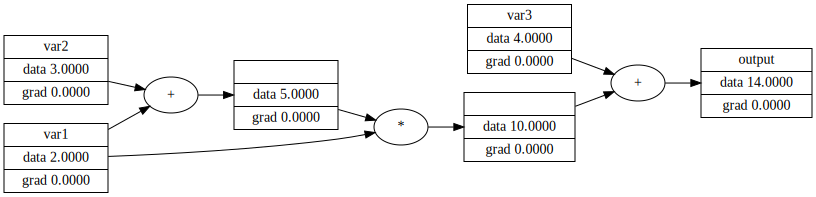

In [132]:
get_expression_graph(output)

In [133]:
# Let's test our autograd implementation by calculating the gradients.
output.backward()

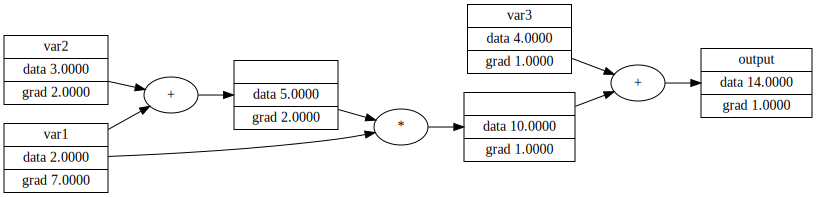

In [134]:
# Let's print the expression graph again to see the gradients.
get_expression_graph(output)
# The gradients are calculated correctly - You can check this from the expression graph in step_5.

#### Lets add tanh function and create a new expression

This will be used to build neural networks in the next step.

In [143]:
# I added the tanh function to the Value class above. Let's modify the above expression slightly to include the tanh
# function and calculate the gradients.
# f(var1, var2, var3) = tanh((var1 + var2) * var1) + var3
# Let's use this function to also calculate the gradients manually and compare the results with the autograd implementation.
def f(var1: Value, var2: Value, var3: Value) -> Value:
    interim1 = var1 + var2
    interim2 = interim1 * var1
    interim3 = interim2.tanh()
    output = interim3 + var3
    interim1.label = "interim1"
    interim2.label = "interim2"
    interim3.label = "interim3"
    output.label = "output"
    print(f"interim2: {interim2}")
    return output

In [150]:
var1 = Value(data=1.0, label="var1")
var2 = Value(data=3.0, label="var2")
var3 = Value(data=4.0, label="var3")
output = f(var1, var2, var3)
print(output)

interim2: label: interim2 | data: 4.0 | operation: * | grad: 0.0
label: output | data: 4.999329299739067 | operation: + | grad: 0.0


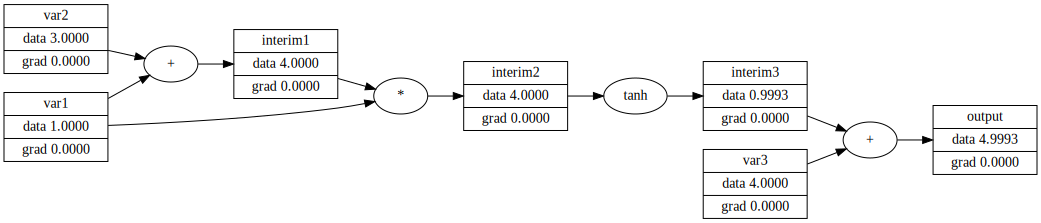

In [157]:
get_expression_graph(root=output)

In [158]:
h = 0.0001

In [162]:
# Let's calculate the gradients manually.
def f_float(var1: float, var2: float, var3: float) -> float:
    interim1 = var1 + var2
    interim2 = interim1 * var1
    interim3 = math.tanh(interim2)
    output = interim3 + var3
    return output

dvar1 = (f_float(var1.data + h, var2.data, var3.data) - f_float(var1.data, var2.data, var3.data)) / h
print(f"dvar1: {dvar1}")
dvar2 = (f_float(var1.data, var2.data + h, var3.data) - f_float(var1.data, var2.data, var3.data)) / h
print(f"dvar2: {dvar2}")
dvar3 = (f_float(var1.data, var2.data, var3.data + h) - f_float(var1.data, var2.data, var3.data)) / h
print(f"dvar3: {dvar3}")

dvar1: 0.006701538364239923
dvar2: 0.001340816684347601
dvar3: 0.9999999999976694


In [163]:
# Now, let's calculate the gradients using the autograd implementation.
output.backward()

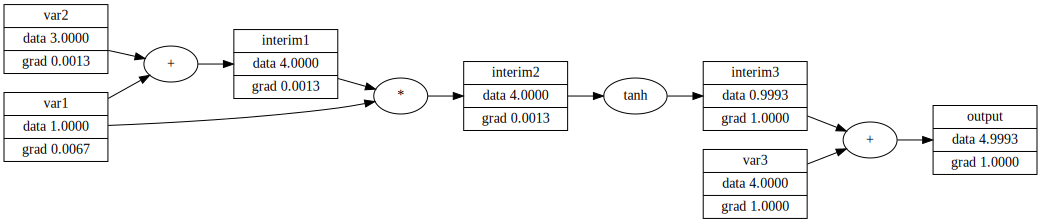

In [164]:
# Let's print the expression graph again to see the gradients.
get_expression_graph(output)
# Notice that the gradients calculated manually exactly match the gradients calculated using the autograd implementation.